# Lab 7:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



## Loading the Keras package
We begin by loading keras and the other packages

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `keras`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
For Unix, you may need to load some additional packages:

    sudo apt-get install build-essential
    sudo apt-get install libxext-dev python-qt4 qt4-dev-tools
    pip install librosa
    
After you have installed the package, try to import it.

In [3]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [4]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO:  Load the file from url and save it in a file under the name fn
r = requests.get(url)
with open(fn,'wb') as f:
    f.write(r.content)

Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [5]:
# TODO
# y, sr = ...
y, sr = librosa.load(fn)

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

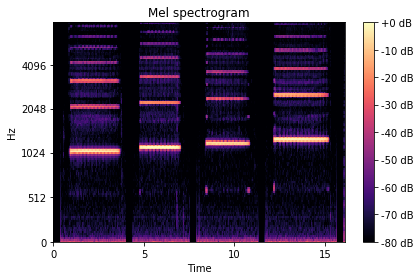

In [6]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, the segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [7]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class.


In [8]:
# TODO
print("The number of traning samples is {}.".format(Xtr.shape[0]))
print("The number of test samples is {}.".format(Xts.shape[0]))
print("The number of features for each sample is {}.".format(Xtr.shape[1]))
print("The number of classes is {}.".format(max(yts)+1))

The number of traning samples is 66247.
The number of test samples is 14904.
The number of features for each sample is 120.
The number of classes is 10.


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [9]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
Xtr_mean = np.mean(Xtr, axis=0)
Xtr_std = np.std(Xtr, axis=0)
Xtr_scale = (Xtr - Xtr_mean[None,:])/Xtr_std[None,:]
# Xts_scale = ...
Xts_mean = np.mean(Xts, axis=0)
Xts_std = np.std(Xts, axis=0)
Xts_scale = (Xts - Xts_mean[None,:])/Xts_std[None,:]

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb), clear the keras session.  Then, create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation for the hidden layer, `softmax` for the output layer
* select the input and output shapes correctly
* print the model summary

In [10]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [11]:
# TODO clear session
keras.backend.clear_session()

In [12]:
# TODO: construct the model
nin = Xtr_scale.shape[1]  # dimension of input data
nh = 256                  # number of hidden units
nout = int(np.max(ytr)+1) # number of outputs = 10 since there are 10 classes
model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='softmax', name='output'))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# TODO:  Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


To keep track of the loss history and validation accuracy, we can use a *callback* function as described in [Keras callback documentation](https://keras.io/callbacks/).  A callback is a class that is passed to the `fit` method.  Here we provide the definition of `LoadHistory` callback class below to save the loss and validation accuracy. This callback class allows you to record the loss at the batch level in addition to at the epoch level. However, for this lab, you could choose to just use the returned history class by model.fit, which will allow you to plot the metrics at the epoch level. For your own practice, you could use this callback class instead of the returned history class to plot the results required below.

In [14]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create four empty lists, self.loss, self.acc, self.val_acc and self.batch_loss
        self.loss = []
        self.acc = []
        self.val_acc = []
        self.batch_loss = []

    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the batch_loss list
        self.batch_loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.
        # Add the traing accuracy in logs.get('acc') to the acc list
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        # Add the training loss in logs.get('loss') to the loss list
        
        self.acc.append(logs.get('acc')) 
        self.val_acc.append(logs.get('val_acc')) 
        self.loss.append(logs.get('loss'))

# Create an instance of the history callback
history_cb = LossHistory()

Create an optimizer and compile the model.  Select the appropriate loss function and metrics.  For the optimizer, use the Adam optimizer with a learning rate of 0.001

In [15]:
# TODO
# opt = ...
opt = keras.optimizers.Adam(lr=0.001) #, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# model.compile(...)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Fit the model for 10 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Also, use the return from model.fit to record the history of loss, accuracy, and validation accuracy in successive epochs. Use a batch size of 100.  Your final accuracy should be >99%. If you want, you could also use the callback class you defined to record the history.

In [16]:
# TODO
batch_size = 100
epochs = 1000
hist = model.fit(Xtr_scale, ytr, epochs=epochs, batch_size=batch_size, 
                 validation_data=(Xts_scale,yts), callbacks=[history_cb])# , verbose=0)


Instructions for updating:
Use tf.cast instead.
Train on 66247 samples, validate on 14904 samples
Epoch 1/1000
66247/66247 [==============================] - 2s 27us/step - loss: 0.3573 - acc: 0.9007 - val_loss: 0.1904 - val_acc: 0.9507
Epoch 2/1000
66247/66247 [==============================] - 1s 22us/step - loss: 0.1006 - acc: 0.9757 - val_loss: 0.1483 - val_acc: 0.9497
Epoch 3/1000
66247/66247 [==============================] - 1s 22us/step - loss: 0.0593 - acc: 0.9858 - val_loss: 0.1279 - val_acc: 0.9559
Epoch 4/1000
66247/66247 [==============================] - 1s 21us/step - loss: 0.0419 - acc: 0.9897 - val_loss: 0.1922 - val_acc: 0.9195
Epoch 5/1000
66247/66247 [==============================] - 1s 21us/step - loss: 0.0317 - acc: 0.9918 - val_loss: 0.1866 - val_acc: 0.9231
Epoch 6/1000
66247/66247 [==============================] - 1s 20us/step - loss: 0.0251 - acc: 0.9932 - val_loss: 0.1802 - val_acc: 0.9279
Epoch 7/1000
66247/66247 [==============================] - 1s 22us/

66247/66247 [==============================] - 1s 22us/step - loss: 0.0010 - acc: 0.9997 - val_loss: 1.0377 - val_acc: 0.8841
Epoch 58/1000
66247/66247 [==============================] - 1s 22us/step - loss: 0.0010 - acc: 0.9997 - val_loss: 1.2060 - val_acc: 0.8748
Epoch 59/1000
66247/66247 [==============================] - 1s 21us/step - loss: 8.4509e-04 - acc: 0.9998 - val_loss: 0.8732 - val_acc: 0.8917
Epoch 60/1000
66247/66247 [==============================] - 2s 24us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 1.2228 - val_acc: 0.8723
Epoch 61/1000
66247/66247 [==============================] - 1s 22us/step - loss: 9.2544e-04 - acc: 0.9997 - val_loss: 1.3769 - val_acc: 0.8666
Epoch 62/1000
66247/66247 [==============================] - 1s 22us/step - loss: 0.0010 - acc: 0.9997 - val_loss: 1.1090 - val_acc: 0.8811
Epoch 63/1000
66247/66247 [==============================] - 1s 21us/step - loss: 9.6570e-04 - acc: 0.9997 - val_loss: 1.2163 - val_acc: 0.8747
Epoch 64/1000
66247/66

66247/66247 [==============================] - 1s 19us/step - loss: 3.1252e-04 - acc: 0.9999 - val_loss: 1.4817 - val_acc: 0.8663
Epoch 115/1000
66247/66247 [==============================] - 1s 20us/step - loss: 1.4646e-04 - acc: 1.0000 - val_loss: 1.4565 - val_acc: 0.8680
Epoch 116/1000
66247/66247 [==============================] - 1s 19us/step - loss: 4.8419e-04 - acc: 0.9998 - val_loss: 1.5344 - val_acc: 0.8647
Epoch 117/1000
66247/66247 [==============================] - 1s 17us/step - loss: 3.1361e-04 - acc: 0.9999 - val_loss: 1.4443 - val_acc: 0.8688
Epoch 118/1000
66247/66247 [==============================] - 1s 18us/step - loss: 4.2850e-04 - acc: 0.9999 - val_loss: 1.4658 - val_acc: 0.8673
Epoch 119/1000
66247/66247 [==============================] - 1s 19us/step - loss: 4.3975e-04 - acc: 0.9998 - val_loss: 1.4230 - val_acc: 0.8704
Epoch 120/1000
66247/66247 [==============================] - 1s 18us/step - loss: 2.0751e-04 - acc: 0.9999 - val_loss: 1.5604 - val_acc: 0.8644


66247/66247 [==============================] - 1s 19us/step - loss: 2.5871e-04 - acc: 0.9999 - val_loss: 1.6967 - val_acc: 0.8586
Epoch 171/1000
66247/66247 [==============================] - 1s 17us/step - loss: 1.4652e-04 - acc: 1.0000 - val_loss: 1.7169 - val_acc: 0.8565
Epoch 172/1000
66247/66247 [==============================] - 1s 20us/step - loss: 1.2242e-04 - acc: 1.0000 - val_loss: 1.6829 - val_acc: 0.8594
Epoch 173/1000
66247/66247 [==============================] - 1s 20us/step - loss: 3.8808e-04 - acc: 0.9999 - val_loss: 1.6206 - val_acc: 0.8600
Epoch 174/1000
66247/66247 [==============================] - 1s 20us/step - loss: 5.4879e-04 - acc: 0.9999 - val_loss: 1.6914 - val_acc: 0.8553
Epoch 175/1000
66247/66247 [==============================] - 1s 20us/step - loss: 3.1412e-05 - acc: 1.0000 - val_loss: 1.6727 - val_acc: 0.8580
Epoch 176/1000
66247/66247 [==============================] - 1s 20us/step - loss: 1.3443e-04 - acc: 1.0000 - val_loss: 1.7672 - val_acc: 0.8552


66247/66247 [==============================] - 1s 20us/step - loss: 7.1624e-04 - acc: 0.9997 - val_loss: 1.9292 - val_acc: 0.8490
Epoch 227/1000
66247/66247 [==============================] - 1s 19us/step - loss: 3.5749e-04 - acc: 0.9999 - val_loss: 1.7929 - val_acc: 0.8531
Epoch 228/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.9974e-05 - acc: 1.0000 - val_loss: 1.7662 - val_acc: 0.8528
Epoch 229/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.8513e-05 - acc: 1.0000 - val_loss: 1.7264 - val_acc: 0.8564
Epoch 230/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.6560e-05 - acc: 1.0000 - val_loss: 1.7140 - val_acc: 0.8567
Epoch 231/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.0123e-05 - acc: 1.0000 - val_loss: 1.7812 - val_acc: 0.8541
Epoch 232/1000
66247/66247 [==============================] - 1s 18us/step - loss: 4.8187e-05 - acc: 1.0000 - val_loss: 1.6638 - val_acc: 0.8606


66247/66247 [==============================] - 1s 18us/step - loss: 1.3955e-05 - acc: 1.0000 - val_loss: 1.7591 - val_acc: 0.8559
Epoch 283/1000
66247/66247 [==============================] - 1s 18us/step - loss: 2.5342e-04 - acc: 0.9999 - val_loss: 1.8900 - val_acc: 0.8509
Epoch 284/1000
66247/66247 [==============================] - 1s 19us/step - loss: 3.1087e-04 - acc: 0.9999 - val_loss: 1.8827 - val_acc: 0.8488
Epoch 285/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.2919e-05 - acc: 1.0000 - val_loss: 1.7988 - val_acc: 0.8521
Epoch 286/1000
66247/66247 [==============================] - 1s 19us/step - loss: 9.7891e-06 - acc: 1.0000 - val_loss: 1.8183 - val_acc: 0.8514
Epoch 287/1000
66247/66247 [==============================] - 1s 18us/step - loss: 3.5044e-04 - acc: 0.9999 - val_loss: 1.8463 - val_acc: 0.8526
Epoch 288/1000
66247/66247 [==============================] - 1s 18us/step - loss: 2.7797e-04 - acc: 0.9999 - val_loss: 1.7973 - val_acc: 0.8543


66247/66247 [==============================] - 1s 17us/step - loss: 5.4751e-04 - acc: 0.9998 - val_loss: 1.8590 - val_acc: 0.8509
Epoch 339/1000
66247/66247 [==============================] - 1s 17us/step - loss: 8.6030e-06 - acc: 1.0000 - val_loss: 1.8572 - val_acc: 0.8518
Epoch 340/1000
66247/66247 [==============================] - 1s 17us/step - loss: 7.4868e-06 - acc: 1.0000 - val_loss: 1.8634 - val_acc: 0.8517
Epoch 341/1000
66247/66247 [==============================] - 1s 17us/step - loss: 2.4938e-04 - acc: 0.9999 - val_loss: 1.8209 - val_acc: 0.8547
Epoch 342/1000
66247/66247 [==============================] - 1s 18us/step - loss: 8.3031e-06 - acc: 1.0000 - val_loss: 1.8267 - val_acc: 0.8547
Epoch 343/1000
66247/66247 [==============================] - 1s 17us/step - loss: 6.4483e-06 - acc: 1.0000 - val_loss: 1.8097 - val_acc: 0.8557
Epoch 344/1000
66247/66247 [==============================] - 1s 18us/step - loss: 7.0962e-06 - acc: 1.0000 - val_loss: 1.7627 - val_acc: 0.8580


66247/66247 [==============================] - 1s 18us/step - loss: 5.6988e-06 - acc: 1.0000 - val_loss: 1.9243 - val_acc: 0.8512
Epoch 395/1000
66247/66247 [==============================] - 1s 17us/step - loss: 4.6571e-04 - acc: 0.9999 - val_loss: 1.9417 - val_acc: 0.8475
Epoch 396/1000
66247/66247 [==============================] - 1s 18us/step - loss: 5.4099e-04 - acc: 0.9999 - val_loss: 1.9408 - val_acc: 0.8496
Epoch 397/1000
66247/66247 [==============================] - 1s 17us/step - loss: 1.6289e-05 - acc: 1.0000 - val_loss: 1.9163 - val_acc: 0.8514
Epoch 398/1000
66247/66247 [==============================] - 1s 18us/step - loss: 5.0926e-06 - acc: 1.0000 - val_loss: 1.8885 - val_acc: 0.8534
Epoch 399/1000
66247/66247 [==============================] - 1s 17us/step - loss: 5.4221e-06 - acc: 1.0000 - val_loss: 1.8792 - val_acc: 0.8534
Epoch 400/1000
66247/66247 [==============================] - 1s 20us/step - loss: 4.0131e-06 - acc: 1.0000 - val_loss: 1.8606 - val_acc: 0.8541


66247/66247 [==============================] - 1s 17us/step - loss: 4.2246e-06 - acc: 1.0000 - val_loss: 1.7361 - val_acc: 0.8600
Epoch 451/1000
66247/66247 [==============================] - 1s 19us/step - loss: 4.0268e-04 - acc: 0.9999 - val_loss: 1.8190 - val_acc: 0.8563
Epoch 452/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.9171e-06 - acc: 1.0000 - val_loss: 1.8525 - val_acc: 0.8545
Epoch 453/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.6390e-06 - acc: 1.0000 - val_loss: 1.8620 - val_acc: 0.8539
Epoch 454/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.6598e-06 - acc: 1.0000 - val_loss: 1.8550 - val_acc: 0.8545
Epoch 455/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.8290e-06 - acc: 1.0000 - val_loss: 1.8853 - val_acc: 0.8532
Epoch 456/1000
66247/66247 [==============================] - 1s 19us/step - loss: 4.4277e-06 - acc: 1.0000 - val_loss: 1.8698 - val_acc: 0.8540


66247/66247 [==============================] - 1s 19us/step - loss: 1.7438e-05 - acc: 1.0000 - val_loss: 1.8959 - val_acc: 0.8502
Epoch 507/1000
66247/66247 [==============================] - 1s 18us/step - loss: 2.3911e-06 - acc: 1.0000 - val_loss: 1.8598 - val_acc: 0.8527
Epoch 508/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.3264e-06 - acc: 1.0000 - val_loss: 1.8672 - val_acc: 0.8521
Epoch 509/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.2290e-06 - acc: 1.0000 - val_loss: 1.9267 - val_acc: 0.8491
Epoch 510/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.5180e-06 - acc: 1.0000 - val_loss: 1.9115 - val_acc: 0.8503
Epoch 511/1000
66247/66247 [==============================] - 1s 20us/step - loss: 6.1501e-04 - acc: 0.9999 - val_loss: 1.9169 - val_acc: 0.8529
Epoch 512/1000
66247/66247 [==============================] - 1s 18us/step - loss: 7.1641e-04 - acc: 0.9998 - val_loss: 1.9796 - val_acc: 0.8493


66247/66247 [==============================] - 1s 17us/step - loss: 5.3656e-06 - acc: 1.0000 - val_loss: 1.8437 - val_acc: 0.8568
Epoch 563/1000
66247/66247 [==============================] - 1s 17us/step - loss: 2.3135e-06 - acc: 1.0000 - val_loss: 1.8055 - val_acc: 0.8588
Epoch 564/1000
66247/66247 [==============================] - 1s 17us/step - loss: 2.7083e-06 - acc: 1.0000 - val_loss: 1.8011 - val_acc: 0.8594
Epoch 565/1000
66247/66247 [==============================] - 1s 17us/step - loss: 1.8607e-06 - acc: 1.0000 - val_loss: 1.7815 - val_acc: 0.8602
Epoch 566/1000
66247/66247 [==============================] - 1s 17us/step - loss: 1.9616e-06 - acc: 1.0000 - val_loss: 1.7840 - val_acc: 0.8602
Epoch 567/1000
66247/66247 [==============================] - 1s 17us/step - loss: 1.8309e-06 - acc: 1.0000 - val_loss: 1.8149 - val_acc: 0.8589
Epoch 568/1000
66247/66247 [==============================] - 1s 18us/step - loss: 7.3484e-05 - acc: 1.0000 - val_loss: 1.8227 - val_acc: 0.8575


66247/66247 [==============================] - 1s 19us/step - loss: 1.4989e-06 - acc: 1.0000 - val_loss: 1.8610 - val_acc: 0.8578
Epoch 619/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.5248e-06 - acc: 1.0000 - val_loss: 1.8719 - val_acc: 0.8570
Epoch 620/1000
66247/66247 [==============================] - 1s 17us/step - loss: 9.9418e-04 - acc: 0.9999 - val_loss: 1.9503 - val_acc: 0.8534
Epoch 621/1000
66247/66247 [==============================] - 1s 18us/step - loss: 5.3761e-06 - acc: 1.0000 - val_loss: 1.8980 - val_acc: 0.8538
Epoch 622/1000
66247/66247 [==============================] - 1s 18us/step - loss: 3.0893e-06 - acc: 1.0000 - val_loss: 1.8844 - val_acc: 0.8550
Epoch 623/1000
66247/66247 [==============================] - 1s 17us/step - loss: 2.7443e-06 - acc: 1.0000 - val_loss: 1.8744 - val_acc: 0.8551
Epoch 624/1000
66247/66247 [==============================] - 1s 18us/step - loss: 2.4547e-06 - acc: 1.0000 - val_loss: 1.8610 - val_acc: 0.8555


66247/66247 [==============================] - 1s 18us/step - loss: 1.9983e-06 - acc: 1.0000 - val_loss: 1.9864 - val_acc: 0.8504
Epoch 675/1000
66247/66247 [==============================] - 1s 19us/step - loss: 1.8622e-06 - acc: 1.0000 - val_loss: 1.9818 - val_acc: 0.8505
Epoch 676/1000
66247/66247 [==============================] - 1s 19us/step - loss: 1.8527e-06 - acc: 1.0000 - val_loss: 1.9692 - val_acc: 0.8512
Epoch 677/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.5729e-06 - acc: 1.0000 - val_loss: 1.9630 - val_acc: 0.8514
Epoch 678/1000
66247/66247 [==============================] - 1s 19us/step - loss: 1.4472e-06 - acc: 1.0000 - val_loss: 1.9440 - val_acc: 0.8525
Epoch 679/1000
66247/66247 [==============================] - 1s 19us/step - loss: 1.6618e-06 - acc: 1.0000 - val_loss: 1.9289 - val_acc: 0.8529
Epoch 680/1000
66247/66247 [==============================] - 1s 20us/step - loss: 1.6875e-06 - acc: 1.0000 - val_loss: 1.9352 - val_acc: 0.8534


66247/66247 [==============================] - 1s 18us/step - loss: 1.4939e-06 - acc: 1.0000 - val_loss: 1.8676 - val_acc: 0.8589
Epoch 731/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.4407e-06 - acc: 1.0000 - val_loss: 1.8579 - val_acc: 0.8596
Epoch 732/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.3556e-06 - acc: 1.0000 - val_loss: 1.8499 - val_acc: 0.8598
Epoch 733/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.2854e-06 - acc: 1.0000 - val_loss: 1.8877 - val_acc: 0.8574
Epoch 734/1000
66247/66247 [==============================] - 1s 18us/step - loss: 4.9282e-04 - acc: 0.9999 - val_loss: 1.9230 - val_acc: 0.8537
Epoch 735/1000
66247/66247 [==============================] - 1s 18us/step - loss: 2.7001e-06 - acc: 1.0000 - val_loss: 1.8962 - val_acc: 0.8559
Epoch 736/1000
66247/66247 [==============================] - 1s 18us/step - loss: 2.3378e-06 - acc: 1.0000 - val_loss: 1.8878 - val_acc: 0.8566


66247/66247 [==============================] - 1s 17us/step - loss: 1.4766e-06 - acc: 1.0000 - val_loss: 1.8971 - val_acc: 0.8555
Epoch 787/1000
66247/66247 [==============================] - 1s 19us/step - loss: 1.5471e-06 - acc: 1.0000 - val_loss: 1.8743 - val_acc: 0.8567
Epoch 788/1000
66247/66247 [==============================] - 1s 19us/step - loss: 1.2221e-06 - acc: 1.0000 - val_loss: 1.8572 - val_acc: 0.8572
Epoch 789/1000
66247/66247 [==============================] - 1s 20us/step - loss: 1.6425e-06 - acc: 1.0000 - val_loss: 1.8451 - val_acc: 0.8574
Epoch 790/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.2235e-06 - acc: 1.0000 - val_loss: 1.8769 - val_acc: 0.8564
Epoch 791/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.2113e-06 - acc: 1.0000 - val_loss: 1.8658 - val_acc: 0.8563
Epoch 792/1000
66247/66247 [==============================] - 1s 18us/step - loss: 5.6300e-04 - acc: 0.9998 - val_loss: 1.8341 - val_acc: 0.8601


66247/66247 [==============================] - 1s 19us/step - loss: 4.1431e-06 - acc: 1.0000 - val_loss: 1.9003 - val_acc: 0.8551
Epoch 843/1000
66247/66247 [==============================] - 1s 19us/step - loss: 2.3785e-06 - acc: 1.0000 - val_loss: 1.8697 - val_acc: 0.8573
Epoch 844/1000
66247/66247 [==============================] - 1s 18us/step - loss: 2.2338e-06 - acc: 1.0000 - val_loss: 1.8713 - val_acc: 0.8572
Epoch 845/1000
66247/66247 [==============================] - 1s 22us/step - loss: 2.0259e-06 - acc: 1.0000 - val_loss: 1.8598 - val_acc: 0.8580
Epoch 846/1000
66247/66247 [==============================] - 1s 17us/step - loss: 2.0352e-06 - acc: 1.0000 - val_loss: 1.8481 - val_acc: 0.8590
Epoch 847/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.5864e-06 - acc: 1.0000 - val_loss: 1.8560 - val_acc: 0.8588
Epoch 848/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.4373e-06 - acc: 1.0000 - val_loss: 1.8564 - val_acc: 0.8589


66247/66247 [==============================] - 1s 17us/step - loss: 2.0734e-06 - acc: 1.0000 - val_loss: 2.0291 - val_acc: 0.8488
Epoch 899/1000
66247/66247 [==============================] - 1s 20us/step - loss: 1.9646e-06 - acc: 1.0000 - val_loss: 2.0251 - val_acc: 0.8490
Epoch 900/1000
66247/66247 [==============================] - 1s 19us/step - loss: 1.8284e-06 - acc: 1.0000 - val_loss: 2.0160 - val_acc: 0.8495
Epoch 901/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.6044e-06 - acc: 1.0000 - val_loss: 2.0023 - val_acc: 0.8499
Epoch 902/1000
66247/66247 [==============================] - 1s 17us/step - loss: 1.5670e-06 - acc: 1.0000 - val_loss: 2.0204 - val_acc: 0.8492
Epoch 903/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.4445e-06 - acc: 1.0000 - val_loss: 1.9902 - val_acc: 0.8501
Epoch 904/1000
66247/66247 [==============================] - 1s 20us/step - loss: 1.3687e-06 - acc: 1.0000 - val_loss: 1.9711 - val_acc: 0.8513


66247/66247 [==============================] - 1s 19us/step - loss: 1.0938e-06 - acc: 1.0000 - val_loss: 1.9435 - val_acc: 0.8547
Epoch 955/1000
66247/66247 [==============================] - 1s 18us/step - loss: 3.5813e-04 - acc: 0.9999 - val_loss: 1.9418 - val_acc: 0.8546
Epoch 956/1000
66247/66247 [==============================] - 1s 18us/step - loss: 4.0443e-06 - acc: 1.0000 - val_loss: 1.9020 - val_acc: 0.8572
Epoch 957/1000
66247/66247 [==============================] - 1s 19us/step - loss: 1.2034e-06 - acc: 1.0000 - val_loss: 1.9133 - val_acc: 0.8565
Epoch 958/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.2690e-06 - acc: 1.0000 - val_loss: 1.9312 - val_acc: 0.8554
Epoch 959/1000
66247/66247 [==============================] - 1s 19us/step - loss: 7.3693e-04 - acc: 0.9998 - val_loss: 1.9834 - val_acc: 0.8514
Epoch 960/1000
66247/66247 [==============================] - 1s 18us/step - loss: 1.7984e-06 - acc: 1.0000 - val_loss: 1.9972 - val_acc: 0.8506


Plot the training loss, accuracy and validation accuracy vs. epoch, using the returned history record from model.fit. You should produce two subplots. One subplot contains the curve of loss vs. epochs. The other subplot contains two curves, one for the training accuracy and another for the validation accuracy. You should see that the loss continuously decreases, the accuracy continuously increases, but the validation accuracy saturates at a little higher than 99%.  After that it "bounces around" due to the noise in the stochastic gradient descent.

You coluld also try to plot the loss values saved in the `history_cb` class.  In addition to plot the metrics for every epoch, you could plot the `batch_loss` per batch. But your may want to plot the x-axis in epochs.  Note that the epoch in step `i` is `epoch = i*batch_size/ntr` where `batch_size` is the batch_size and `ntr` is the total number of training samples.

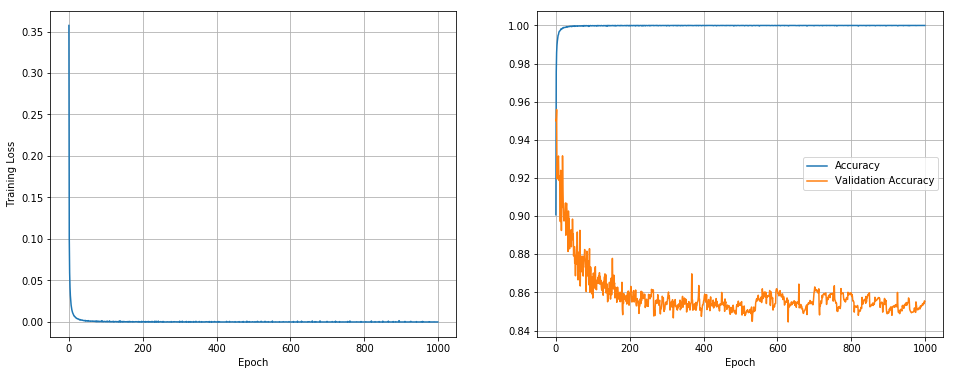

In [17]:
# TODO
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid()
plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['acc'],label='Accuracy')
plt.plot(hist.epoch,hist.history['val_acc'],label='Validation Accuracy')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying three learning rates as shown in the vector `rates`.  For each learning rate:
* clear the session
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model
* save the accuracy and losses

In [18]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
acc_hist = []
val_acc_hist = []

# TODO
for i, lr in enumerate(rates):
    # Clear session
    keras.backend.clear_session()
    # Construct the model
    nin = Xtr_scale.shape[1]  # dimension of input data
    nh = 256                  # number of hidden units
    nout = int(np.max(ytr)+1) # number of outputs = 10 since there are 10 classes
    model = Sequential()
    model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(units=nout, activation='softmax', name='output'))
    # Print the model summary
    model.summary()
    # Oprimizer
    opt = keras.optimizers.Adam(lr=lr) #, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # Model
    model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    hist = model.fit(Xtr_scale, ytr, epochs=epochs, batch_size=batch_size, 
                     validation_data=(Xts_scale,yts), callbacks=[history_cb], verbose=0)
    loss_hist.append(hist.history['loss'])
    acc_hist.append(hist.history['acc'])
    val_acc_hist.append(hist.history['val_acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
La

Plot the loss funciton vs. the epoch number for all three learning rates on one graph.  You should see that the lower learning rates are more stable, but converge slower. Similarly, plot the accuracy and validation accuracy and make your observations. You may want to plot the three set of figures as three subplots.

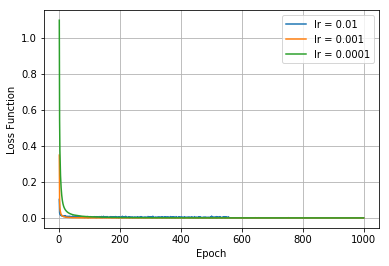

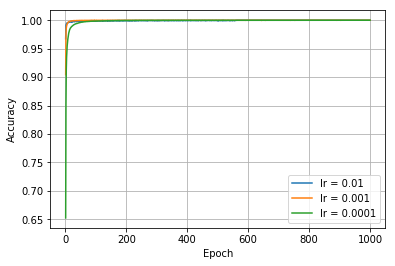

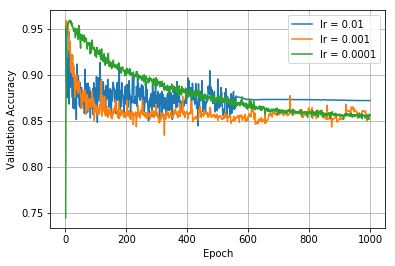

In [19]:
# TODO
x = np.array(range(epochs)) + 1
plt.figure()
plt.plot(x,loss_hist[0],x,loss_hist[1],x,loss_hist[2])
plt.legend(('lr = ' + str(rates[0]),'lr = ' + str(rates[1]),'lr = ' + str(rates[2])))
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.show()
plt.figure()
plt.plot(x,acc_hist[0],x,acc_hist[1],x,acc_hist[2])
plt.legend(('lr = ' + str(rates[0]),'lr = ' + str(rates[1]),'lr = ' + str(rates[2])))
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.figure()
plt.plot(x,val_acc_hist[0],x,val_acc_hist[1],x,val_acc_hist[2])
plt.legend(('lr = ' + str(rates[0]),'lr = ' + str(rates[1]),'lr = ' + str(rates[2])))
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

Question: Which learning rate is the best ?

Answer: 
- All the learning rates converges to to 0.86 approximately. Larger values have a fast convergence, but are not stable, while smaller ones converge slowly.
- The best fastest is rate = 0.001, because it converges rapidly and doesn't varies too much.
- The best rate is 0.0001, bacuse it converges steadily without much variation.